<h2>🔍 FreshCart Churn Prediction - Model Evaluation & Interpretation</h2>
 
<h4>
    <b>
        Zero2End Machine Learning Bootcamp - Final Project
    </b>
</h4>

<h3>
    📋 Notebook Contents
</h3>

<ol>
    <li>Load Final Model</li>
    <li>Confusion Matrix & Error Analysis</li>
    <li>Feature Importance Analysis</li>
    <li>SHAP Values & Interpretation</li>
    <li>Partial Dependence Plots</li>
    <li>Business Metrics & Validation</li>
    <li>Model Decision Analysis</li>
</ol>

<hr>

In [4]:
# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys
import json

import lightgbm as lgb
import shap
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve,
    roc_auc_score, average_precision_score
)
import joblib

In [5]:
# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [6]:
# Add src to path
sys.path.append('../src')

In [7]:
from config import PROCESSED_DATA_DIR, MODEL_DIR, RANDOM_STATE, BUSINESS_METRICS

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


<h4>
    1️⃣ Load Final Model and Data
</h4>

In [8]:
# Load final model
print("📦 Loading final model and data...")

final_model = joblib.load(MODEL_DIR / 'final_model_optimized.pkl')

with open(MODEL_DIR / 'final_metrics.json', 'r') as f:
    final_metrics = json.load(f)

with open(MODEL_DIR / 'feature_names.json', 'r') as f:
    feature_names = json.load(f)

📦 Loading final model and data...


In [10]:
# Load data
final_features = pd.read_parquet(PROCESSED_DATA_DIR / 'final_features_advanced.parquet')

X = final_features[feature_names].fillna(0)
y = final_features['is_churn']

In [11]:
# Split (same as training)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"✅ Model and data loaded")
print(f"   Test set: {X_test.shape}")
print(f"   Model performance (F1): {final_metrics['f1']:.4f}")

✅ Model and data loaded
   Test set: (41242, 53)
   Model performance (F1): 1.0000


In [13]:
# Get predictions
y_pred = (final_model.predict(X_test) > 0.5).astype(int)
y_pred_proba = final_model.predict(X_test)

print("\n📊 Prediction distribution:")
print(f"   Predicted Churned: {y_pred.sum():,} ({y_pred.mean():.2%})")
print(f"   Predicted Active:  {(y_pred == 0).sum():,} ({(y_pred == 0).mean():.2%})")
print(f"   Actual Churned:    {y_test.sum():,} ({y_test.mean():.2%})")



📊 Prediction distribution:
   Predicted Churned: 40,924 (99.23%)
   Predicted Active:  318 (0.77%)
   Actual Churned:    40,924 (99.23%)


<h4>
    2️⃣ Confusion Matrix & Error Analysis
</h4>

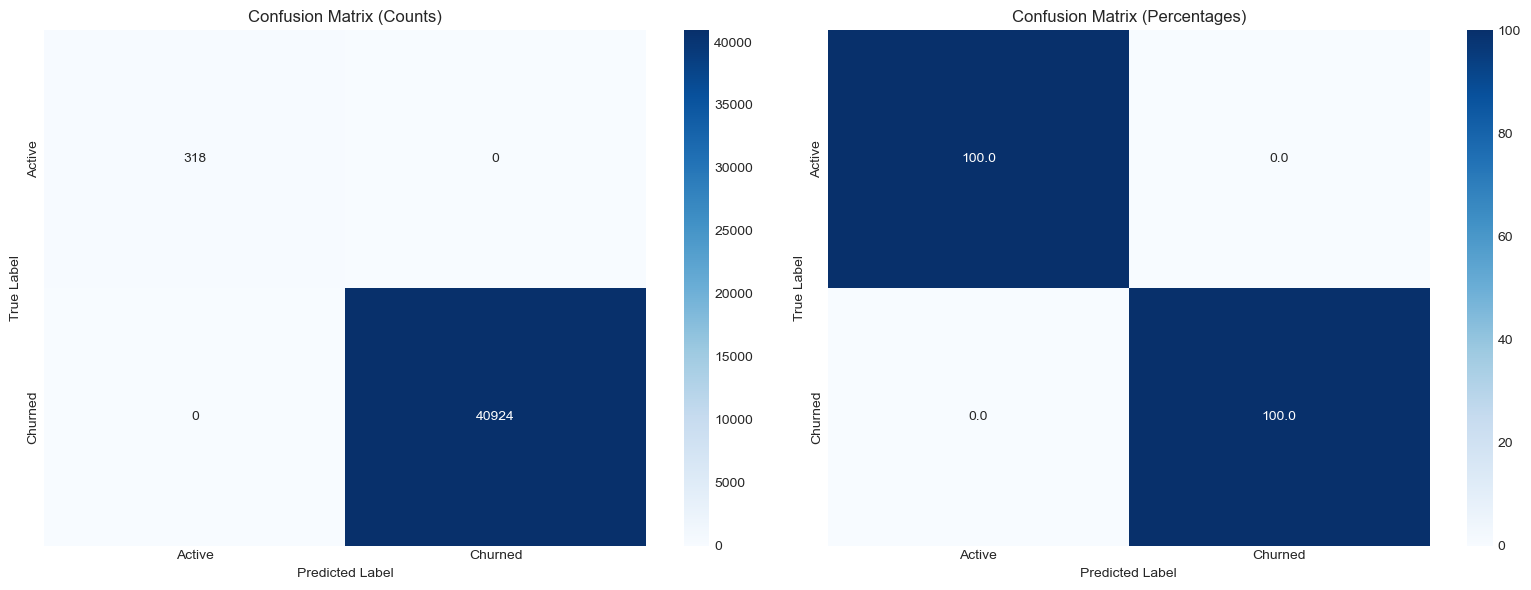

In [14]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix (counts)
ax = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
            xticklabels=['Active', 'Churned'],
            yticklabels=['Active', 'Churned'])
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.set_title('Confusion Matrix (Counts)')

# Confusion matrix (percentages)
ax = axes[1]
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='Blues', ax=ax,
            xticklabels=['Active', 'Churned'],
            yticklabels=['Active', 'Churned'])
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.set_title('Confusion Matrix (Percentages)')

plt.tight_layout()
plt.savefig('../plots/12_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# Classification report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Active', 'Churned']))

# Calculate business metrics
tn, fp, fn, tp = cm.ravel()

print(f"\n💼 Business Interpretation:")
print(f"   True Negatives (TN):  {tn:>6,} - Correctly identified active customers")
print(f"   False Positives (FP): {fp:>6,} - Active customers wrongly flagged as churn")
print(f"   False Negatives (FN): {fn:>6,} - Missed churned customers (BAD!)")
print(f"   True Positives (TP):  {tp:>6,} - Correctly identified churning customers")


📋 Classification Report:
              precision    recall  f1-score   support

      Active       1.00      1.00      1.00       318
     Churned       1.00      1.00      1.00     40924

    accuracy                           1.00     41242
   macro avg       1.00      1.00      1.00     41242
weighted avg       1.00      1.00      1.00     41242


💼 Business Interpretation:
   True Negatives (TN):     318 - Correctly identified active customers
   False Positives (FP):      0 - Active customers wrongly flagged as churn
   False Negatives (FN):      0 - Missed churned customers (BAD!)
   True Positives (TP):  40,924 - Correctly identified churning customers


<h4>
    3️⃣ ROC and Precision-Recall Curves
</h4>

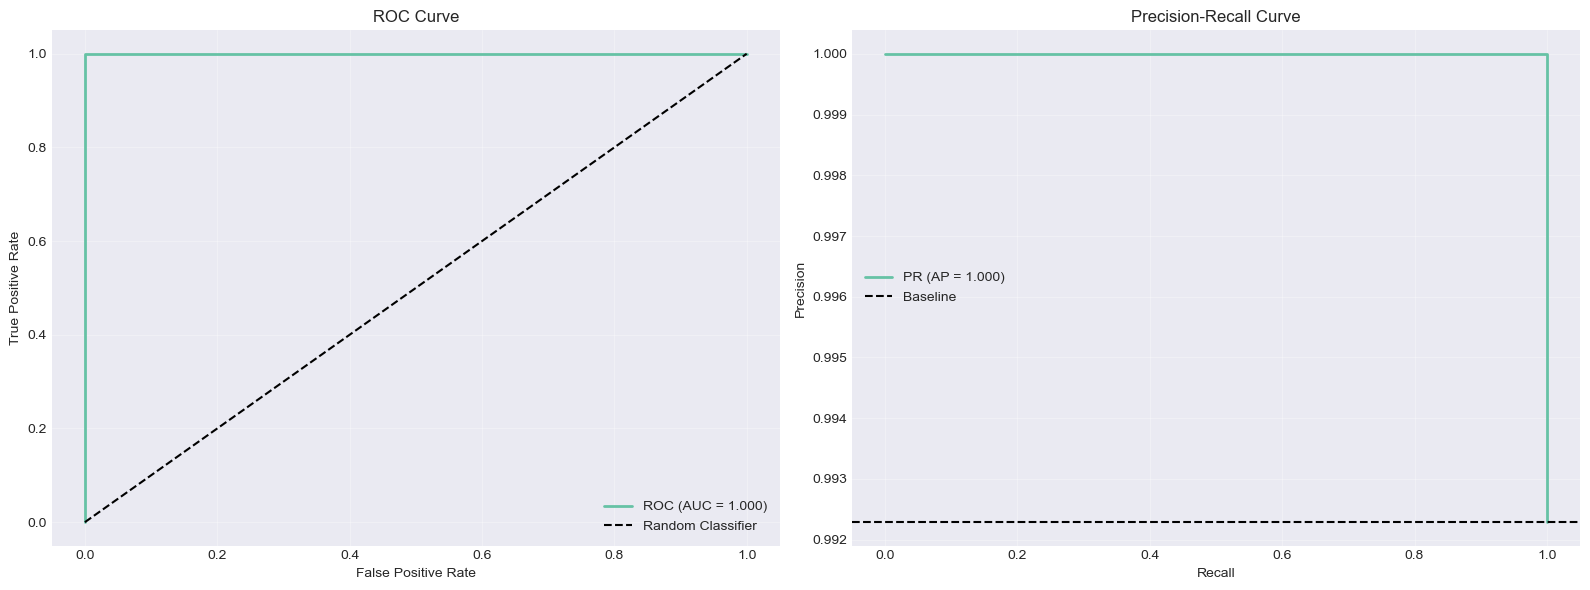

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

ax = axes[0]
ax.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend()
ax.grid(True, alpha=0.3)

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

ax = axes[1]
ax.plot(recall, precision, linewidth=2, label=f'PR (AP = {avg_precision:.3f})')
ax.axhline(y=y_test.mean(), color='k', linestyle='--', label='Baseline')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../plots/13_roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

<h4>
    4️⃣ Feature Importance Analysis
</h4>

In [17]:
# Feature importance from model
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': final_model.feature_importance()
}).sort_values('importance', ascending=False)

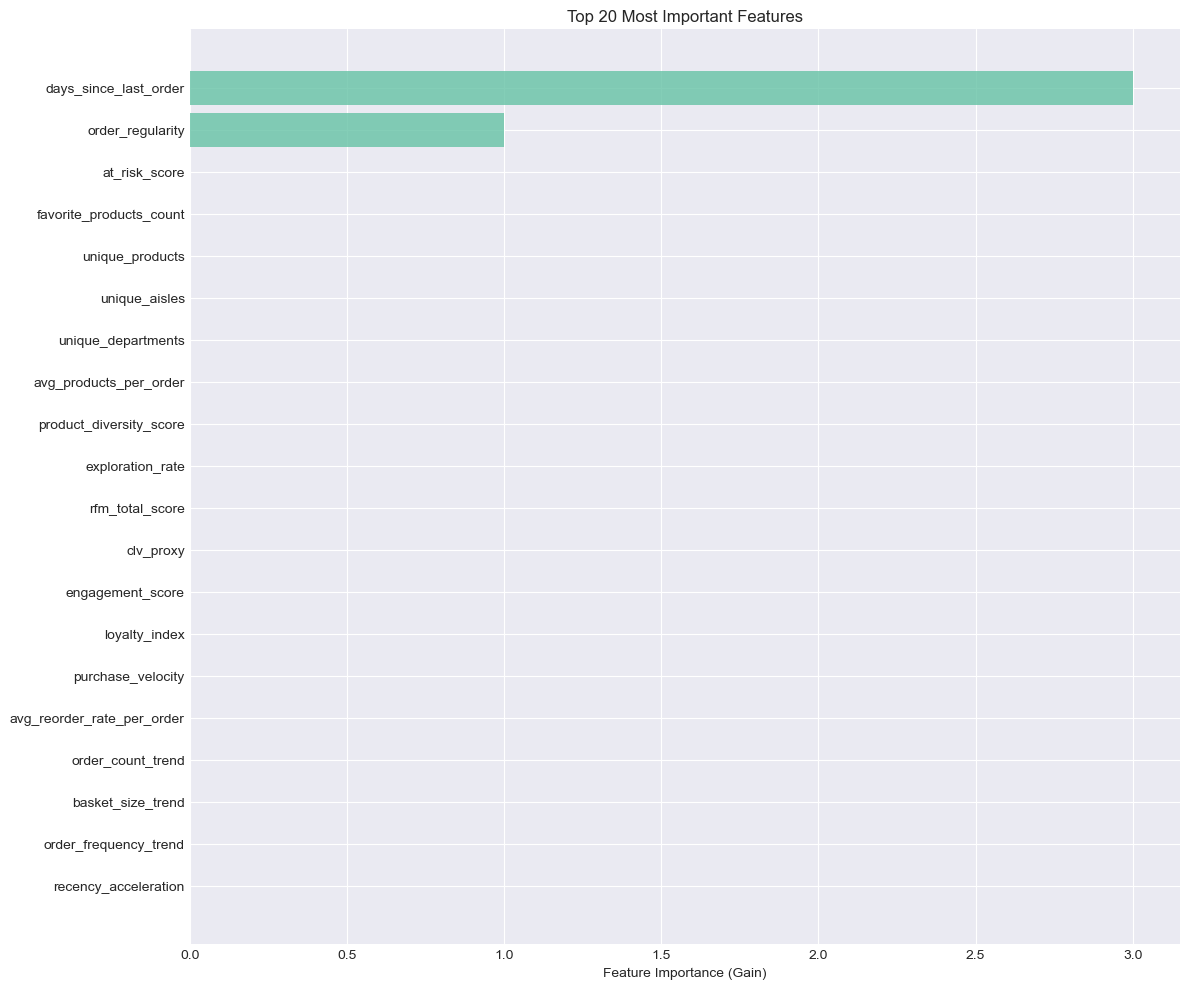


🔝 Top 20 Most Important Features:


,feature,importance
0,days_since_last_order,3
6,order_regularity,1
40,at_risk_score,0
29,favorite_products_count,0
30,unique_products,0
31,unique_aisles,0
32,unique_departments,0
33,avg_products_per_order,0
34,product_diversity_score,0
35,exploration_rate,0


In [18]:
# Plot top 20
fig, ax = plt.subplots(figsize=(12, 10))
top_20 = feature_importance.head(20)
ax.barh(range(len(top_20)), top_20['importance'].values, alpha=0.8)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['feature'].values)
ax.set_xlabel('Feature Importance (Gain)')
ax.set_title('Top 20 Most Important Features')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../plots/14_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🔝 Top 20 Most Important Features:")
display(top_20)

<h4>
    5️⃣ SHAP Values Analysis
</h4>

In [19]:
print("\n🔍 Computing SHAP values...")
print("   This may take a few minutes...")

# Create SHAP explainer
explainer = shap.TreeExplainer(final_model)

# Calculate SHAP values for test set (sample for speed)
sample_size = min(1000, len(X_test))
X_test_sample = X_test.sample(n=sample_size, random_state=RANDOM_STATE)
shap_values = explainer.shap_values(X_test_sample)

print("✅ SHAP values computed!")


🔍 Computing SHAP values...
   This may take a few minutes...
✅ SHAP values computed!


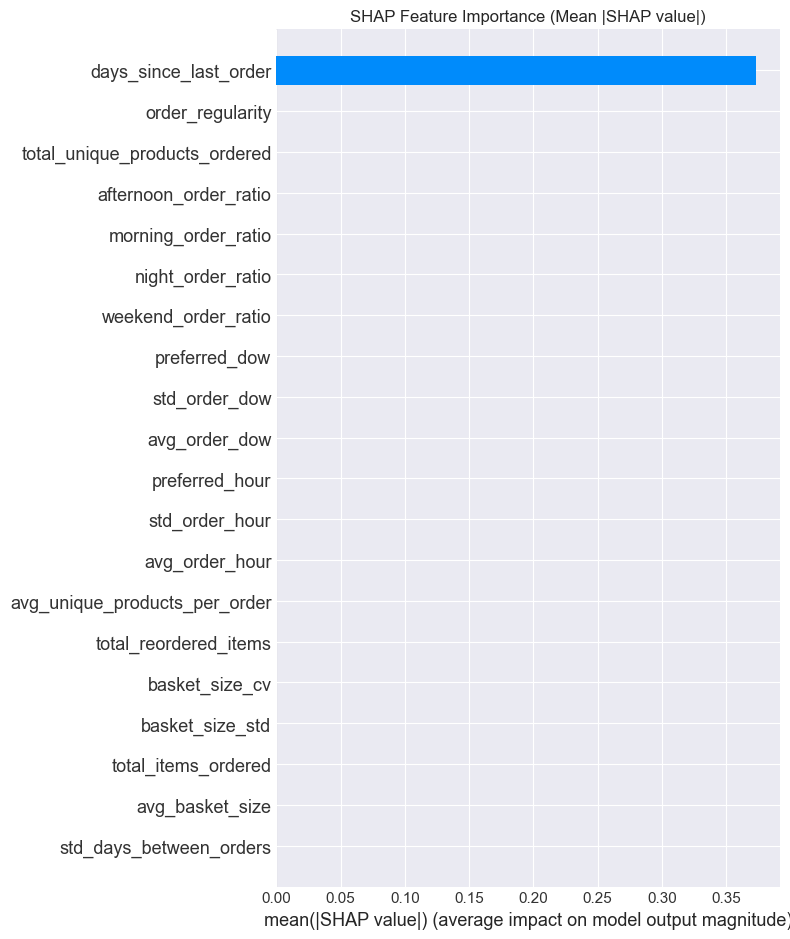

In [21]:
# SHAP Summary Plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Mean |SHAP value|)')
plt.tight_layout()
plt.savefig('../plots/15_shap_importance.png', dpi=300, bbox_inches='tight')
plt.show()

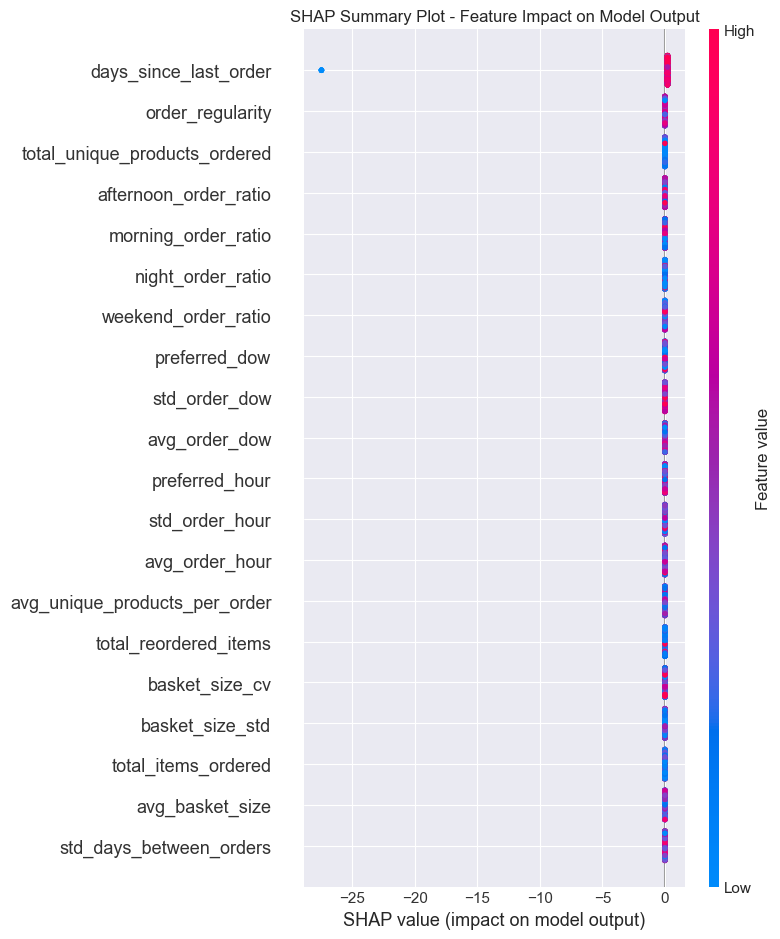

In [22]:
# SHAP Summary Plot (beeswarm)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Model Output')
plt.tight_layout()
plt.savefig('../plots/16_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

<h4>
    6️⃣ Individual Prediction Explanations
</h4>

In [23]:
# Example: Explain a churned customer
churned_customer_idx = y_test[y_test == 1].index[0]
churned_customer = X_test.loc[churned_customer_idx]

print(f"\n👤 Example: Churned Customer (user_id: {churned_customer_idx})")
print(f"   Churn Probability: {final_model.predict([churned_customer])[0]:.2%}")


👤 Example: Churned Customer (user_id: 182078)
   Churn Probability: 99.38%


<Figure size 1600x400 with 0 Axes>

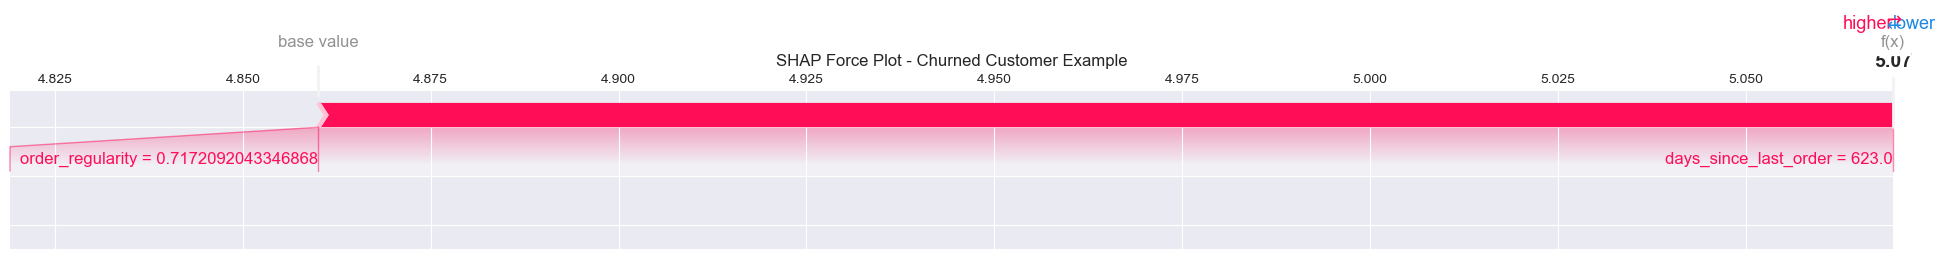

In [24]:
# SHAP force plot
idx_in_sample = X_test_sample.index.get_loc(churned_customer_idx) if churned_customer_idx in X_test_sample.index else 0

plt.figure(figsize=(16, 4))
shap.force_plot(
    explainer.expected_value, 
    shap_values[idx_in_sample], 
    X_test_sample.iloc[idx_in_sample],
    matplotlib=True,
    show=False
)
plt.title('SHAP Force Plot - Churned Customer Example')
plt.tight_layout()
plt.savefig('../plots/17_shap_force_churned.png', dpi=300, bbox_inches='tight')
plt.show()


👤 Example: Active Customer (user_id: 111981)
   Churn Probability: 0.00%


<Figure size 1600x400 with 0 Axes>

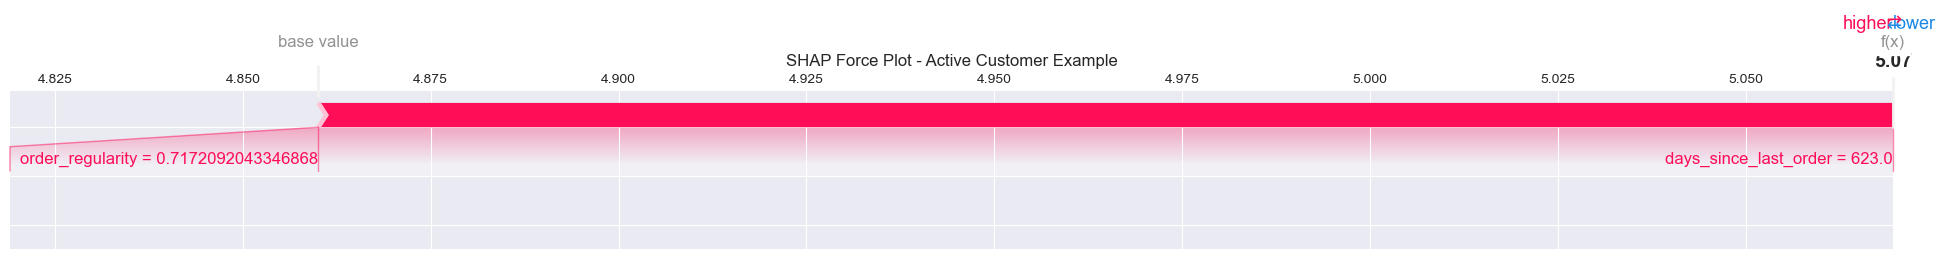

In [25]:
# Example: Active customer
active_customer_idx = y_test[y_test == 0].index[0]
active_customer = X_test.loc[active_customer_idx]

print(f"\n👤 Example: Active Customer (user_id: {active_customer_idx})")
print(f"   Churn Probability: {final_model.predict([active_customer])[0]:.2%}")

idx_in_sample = X_test_sample.index.get_loc(active_customer_idx) if active_customer_idx in X_test_sample.index else 0

plt.figure(figsize=(16, 4))
shap.force_plot(
    explainer.expected_value, 
    shap_values[idx_in_sample], 
    X_test_sample.iloc[idx_in_sample],
    matplotlib=True,
    show=False
)
plt.title('SHAP Force Plot - Active Customer Example')
plt.tight_layout()
plt.savefig('../plots/18_shap_force_active.png', dpi=300, bbox_inches='tight')
plt.show()

<h4>
    7️⃣ SHAP Dependence Plots
</h4>

In [ ]:
# Top 4 features dependence plots
top_features = feature_importance.head(4)['feature'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(top_features):
    shap.dependence_plot(
        feature, 
        shap_values, 
        X_test_sample,
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f'SHAP Dependence Plot: {feature}')

plt.tight_layout()
plt.savefig('../plots/19_shap_dependence.png', dpi=300, bbox_inches='tight')
plt.show()